# IgE Analysis: Overview and Workflow
This notebook provides a comprehensive analysis of IgE (Immunoglobulin E) data in the context of allergy research. The workflow includes:
- Importing and setting up required libraries and custom utilities.
- Loading and preprocessing IgE and survey data, including feature renaming and filtering.
- Exploring overlaps between cross-sectional datasets.
- Preparing IgE data for clustering and downstream analysis.
- Performing hierarchical clustering to identify patterns in IgE profiles.
- Visualizing IgE data distributions and summary statistics.
- Analyzing co-occurrence of IgEs using heatmaps.
- Conducting latent component analysis (PCA and varimax rotation) to uncover underlying allergy patterns.
- Visualizing results with interactive and static plots.
Each section below is accompanied by code and explanations to guide the reader through the analysis steps.


### Imports and Setup

In [ ]:
import os
os.chdir('/container/mount/point/')

import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import scipy.cluster.hierarchy as sch
import pickle as pkl
import IPython.display as display

from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib_venn import venn2
from PIL import Image

In [4]:
# Custom utility imports (adjust paths as needed)
from utils.plotting import (
    presence_absence_heatmap, count_histogram_plot, correlation_heatmap, map_color,
    plot_latent_correlation, plot_missing_percentages
)
from utils.preprocessing import (
    rename_columns, drop_selected_features, drop_zero_features, select_features, aggregate_features,
    threshold_and_get_dropped_columns, drop_zeros, overlap_with_16s_samples, filter_counts, merge_ige,
    intersect_features, replace_imputed_and_empty_with_nan
)
from utils.helper import (
    read_data_from_csv, move_column_to_front, save_dataframe, filter_by_column,
    _flatten_list, calculate_column_counts, _lowercase, _count_missing, transform_features, calculate_log_ratios
)
from utils.heatmap import _get_order, plot_ordered_heatmap

In [5]:
# Display parameters
pd.set_option('display.max_columns', None)
plt.rc('font', weight='bold', size=22)

## Data Dictionary and Feature Mapping
In this section, we define mapping dictionaries to translate raw column names from the IgE and survey datasets into interpretable feature names. This step is crucial for downstream analysis and visualization, ensuring that each variable is clearly understood in the context of IgE-mediated allergy and related clinical or demographic factors. The `ige_mask` dictionary maps IgE test codes to specific allergen names, while `survey_mask` provides readable labels for survey variables.

In [6]:
ige_mask = {    
        ### meat and fish
        'u3g_alpha_gal': 'red_meat',
        'u3g_gad': 'codfish_parvalbumin',

        ### eggs
        'u3g_gal_d_1': 'egg_ovomucoid',
        'u3g_gal_d_2': 'egg_ovalbumin',
        'u3g_gal_d_3': 'egg_conalbumin',
        'u3g_gal_d_5': 'egg_livetin',

        ### cow milk
        'u3g_bos_d_4': 'cow_milk_alpha_lactalbumin',
        'u3g_bos_d_5': 'cow_milk_beta_lactalbumin',
        'u3g_bos_d_8': 'cow_milk_casein',
        'u3g_bos_d_lactofe': 'cow_milk_transferin',
        'u3g_bos_d_6': 'cow_milk_serum_albumin',

        ### shrimp
        'u3g_pen_m_1': 'shrimp_parvalbumin',
        'u3g_pen_m_2': 'shrimp_arginin_kinase',
        'u3g_pen_m_4': 'shrimp_sarco_calcium',

        ### nuts
        'u3g_cor_a_1_0401': 'hazel_nut_pr10',
        'u3g_cor_a_8': 'hazel_nut_lipid_',
        'u3g_cor_a_9': 'hazel_nut_storage',
        'u3g_cor_a_14': 'hazel_nut_a14',
        'u3g_jug_r_1': 'walnut_2s_albumin',
        # 'u3g_jug_r_2': 'walnut_7s_globulin',
        'u3g_jug_r_3': 'walnut_lipid',
        'u3g_ara_h_1': 'peanut_7s_globulin',
        'u3g_ara_h_2': 'peanut_2s_albumin_storage',
        'u3g_ara_h_3': 'peanut_11s_globulin',
        'u3g_ara_h_6': 'peanut_2s_albumin_saver',
        'u3g_ara_h_8': 'peanut_pr10',
        'u3g_ara_h_9': 'peanut_lipid',
        'u3g_ses_i_': 'sesame_nut_2s_albumin',
        'u3g_ana_o_2': 'cashew_nut_o2',
        'u3g_ana_o_3': 'cashew_nut_o3',
        'u3g_ber_e_': 'brazil_nut_2s_albumin',

        ### soy
        'u3g_gly_m_4': 'soy_bean_pr10',
        'u3g_gly_m_5': 'soy_bean_7s_globulin',
        'u3g_gly_m_6': 'soy_bean_11s_globulin',

        ### wheat
        'u3g_fag_e_': 'buck_wheat_2s_albumin',
        'u3g_tri_a_14': 'wheat_lipid',
        'u3g_tri_a_19': 'wheat_omega5_gliadin',
        'u3g_tri_a_a': 'wheat_alpha_amylase',

        ### fruits and vegetables
        'u3g_act_d_1': 'kiwi_cystein_protease',
        'u3g_act_d_2': 'kiwi_thaumatin',
        'u3g_act_d_5': 'kiwi_kiwelin',
        'u3g_act_d_8': 'kiwi_pr10',
        'u3g_pru_p_1': 'peach_pr10',
        'u3g_pru_p_3': 'peach_lipid',
        'u3g_mal_d': 'apple_pr10',
        'u3g_api_g':'celery_pr10',
    
        ### cat
        'u3g_fel_d_1': 'cat_d1',
        'u3g_fel_d_2': 'cat_d2',
        'u3g_fel_d_4': 'cat_d4',
        
        ### HDM
        'u3g_lep_d_': 'storage_mite',
        'u3g_blo_t_': 'dust_mite_blo',
        'u3g_der_f_1': 'dust_mite_far_1',
        'u3g_der_f_2': 'dust_mite_far_2',
        'u3g_der_p_1': 'dust_mite_pter_p1',
        'u3g_der_p_2': 'dust_mite_pter_p2',
        'u3g_der_p_10': 'dust_mite_pter_p10',
        'u3g_der_p_23': 'dust_mite_pter_p23',
    
        ### Cockroach
        'u3g_bla_g_1': 'german_cockroach_g1',
        'u3g_bla_g_2': 'german_cockroach_g2',
        'u3g_bla_g_5': 'german_cockroach_g5',
        'u3g_bla_g_7': 'german_cockroach_g7',
    
        ### Mould Allergens
    
        'u3g_alt_a_1': 'mould_alt_a1',
        'u3g_alt_a_6': 'mould_alt_a6',
        'u3g_asp_f_1': 'mould_asp_f1',
        'u3g_asp_f_3': 'mould_asp_f3',
        'u3g_asp_f_6': 'mould_asp_f6',
        'u3g_cla_h_': 'mould_cla',
    
        ### Pollen
        'u3g_pla_a_1': 'sycamore_tree_a1',
        'u3g_pla_a_3': 'sycamore_tree_a3',
        'u3g_ole_e_1': 'olive_tree_e1',
        'u3g_ole_e_7': 'olive_tree_e7',
        'u3g_ole_e_9': 'olive_tree_e9',
        'u3g_phl_p_1': 'timothy_grass_p1',
        'u3g_phl_p_2': 'timothy_grass_p2',
        'u3g_phl_p_4': 'timothy_grass_p4',
        'u3g_phl_p_5': 'timothy_grass_p5',
        'u3g_phl_p_6': 'timothy_grass_p6',
        'u3g_phl_p_7': 'timothy_grass_p7',
        'u3g_phl_p_11': 'timothy_grass_p11',
        'u3g_phl_p_12': 'timothy_grass_p12',
        'u3g_cyn_d_1': 'bermuda_grass',
    
        ### Weed
        'u3g_amb_a': 'common_ragweed',
        'u3g_art_v_1': 'mug_wort_v1',
        'u3g_art_v_3': 'mug_wort_v3',
        'u3g_che_a': 'white_goose_foot',
        'u3g_mer_a': 'annual_mercury',
        'u3g_par_j': 'apreading_pellitory',
        'u3g_pla_l_1': 'english_platain',
        'u3g_sal_k_1': 'prickly_saltwort',
    
        ### Animal dander
        'u3g_ani_s': 'herring_worm',
        'u3g_mus_m_': 'mouse',
        'u3g_can_f_1': 'dog_f1',
        'u3g_can_f_2': 'dog_f2',
        'u3g_can_f_3': 'dog_f3',
        'u3g_can_f_4': 'dog_f4',
        'u3g_can_f_5': 'dog_f5',
        'u3g_can_f_6': 'dog_f6',
        'u3g_can_f_': 'dog',
        'u3g_equ_c_1': 'horse_c1',
        'u3g_equ_c_3': 'horse_c3',
    
        ### Latex
        'u3g_hev_b_1': 'latex_b1',
        'u3g_hev_b3': 'latex_b3',
        'u3g_hev_b5': 'latex_b5',
        'u3g_hev_b_6': 'latex_b6',
        'u3g_hev_b_8': 'latex_b8',
        
        ### Other
        'u3g_muxf3': 'bromelain',
        'u3g_aln_g_1': 'alder',
        'u3g_cry_j': 'jpn_red_cedar',
        'u3g_bet_v_1': 'birch_v1',
        'u3g_bet_v_2': 'birch_v2',
        'u3g_bet_v_4': 'birch_v4',
        'u3g_cup_a_1': 'arizona_cypress',
        'u3g_ige': 'IgE',
        'u3g_igg': 'IgG',


        ### non-food
        'u3g_ige': 'IgE',
        'u3g_igg': 'IgG',
        'u3g_fel_d_1': 'cat_d1',
        'u3g_fel_d_2': 'cat_d2',
        'u3g_fel_d_4': 'cat_d4',
        'u3g_lep_d_': 'storage_mite',
        'u3g_bla_g_1': 'german_cockroach_g1',
        'u3g_bla_g_2': 'german_cockroach_g2',
        'u3g_bla_g_5': 'german_cockroach_g5',
        'u3g_bla_g_7': 'german_cockroach_g7',
        'u3g_ani_s': 'herring_worm',
        'u3g_hev_b_1': 'latex_b1',
        'u3g_hev_b3': 'latex_b3',
        'u3g_hev_b5': 'latex_b5',
        'u3g_hev_b_6': 'latex_b6',
        'u3g_hev_b_8': 'latex_b8',
        'u3g_muxf3': 'bromelain',
        'u3g_mus_m_': 'mouse',
        'u3g_alt_a_1': 'mould_alt_a1',
        'u3g_alt_a_6': 'mould_alt_a6',                    
        'u3g_asp_f_1': 'mould_asp_f1',
        'u3g_asp_f_3': 'mould_asp_f3',
        'u3g_asp_f_6': 'mould_asp_f6',
        'u3g_cla_h_': 'mould_cla',
        'u3g_blo_t_': 'dust_mite_blo',
        'u3g_der_f_1': 'dust_mite_far_1',
        'u3g_der_f_2': 'dust_mite_far_2',
        'u3g_der_p_1': 'dust_mite_pter_p1',
        'u3g_der_p_2': 'dust_mite_pter_p2',
        'u3g_der_p_10': 'dust_mite_pter_p10',
        'u3g_der_p_23': 'dust_mite_pter_p23',
        'u3g_pla_a_1': 'sycamore_tree_a1',
        'u3g_pla_a_3': 'sycamore_tree_a3',
        'u3g_amb_a': 'common_ragweed',
        'u3g_art_v_1': 'mug_wort_v1',
        'u3g_art_v_3': 'mug_wort_v3',
        'u3g_che_a': 'white_goose_foot',
        'u3g_mer_a': 'annual_mercury',
        'u3g_par_j': 'apreading_pellitory',
        'u3g_pla_l_1': 'english_platain',
        'u3g_sal_k_1': 'prickly_saltwort',
        'u3g_can_f_1': 'dog_f1',
        'u3g_can_f_2': 'dog_f2',
        'u3g_can_f_3': 'dog_f3',
        'u3g_can_f_4': 'dog_f4',
        'u3g_can_f_5': 'dog_f5',
        'u3g_can_f_6': 'dog_f6',
        'u3g_can_f_': 'dog',
        'u3g_equ_c_1': 'horse_c1',
        'u3g_equ_c_3': 'horse_c3',
        'u3g_ole_e_1':  'olive_tree_e1',
        'u3g_ole_e_7':  'olive_tree_e7',
        'u3g_ole_e_9':  'olive_tree_e9',
        'u3g_cup_a_1': 'arizona_cypress',
        'u3g_cry_j': 'jpn_red_cedar',
        'u3g_bet_v_1': 'birch_v1',
        'u3g_bet_v_2': 'birch_v2',
        'u3g_bet_v_4': 'birch_v4',
        'u3g_phl_p_1': 'timothy_grass_p1',
        'u3g_phl_p_2': 'timothy_grass_p2',
        'u3g_phl_p_4': 'timothy_grass_p4',
        'u3g_phl_p_5': 'timothy_grass_p5',
        'u3g_phl_p_6': 'timothy_grass_p6',
        'u3g_phl_p_7': 'timothy_grass_p7',
        'u3g_phl_p_11': 'timothy_grass_p11',
        'u3g_phl_p_12': 'timothy_grass_p12',
        'u3g_cyn_d_1': 'bermuda_grass',
        'u3g_aln_g_1': 'alder'
    }

survey_mask = {'u3talter': 'age', 'u3talteru': 'age exm', 'u3csex': 'sex', 'u3tschul': 'education',
              'u3tgewi': 'weight', 'u3tbmi': 'bmi', 'u3twhrat': 'waist-hip-ratio', 
              'u3twaiidf': 'waist circumference', 'u3tresi': 'BIA avg resist', 
              'u3treak': 'BIA avg react', 'u3tphaw': 'BIA avg phase angle', 
              'u3tasmm': 'muscle_mass', 'u3tphys': 'phys_activ', 'u3tpyrs': 'cig pack years',
              'u3tpyrs_ai': 'cig pack years(acc)', 'u3talkkon': 'alcohol', 'u3twein': 'wein',
              'u3tbier': 'beer', 'u3thyact': 'hypertension', 'u3da9': 'wheezing', 'u3da10e': 'medicine',
              'u3da13aa': 'asthma', 'u3tmace': 'ace inhibitors', 'u3tmata': 'angiotensin_ant',
              'u3tmhypot': 'antihypertensives(other)', 'u3tantihy': 'antihypertensives', 
              'u3tmnitro': 'nitrates', 'u3tmanalep': 'analeptics', 'u3tmppi': 'proton_pump_inh',
              'u3tglukfasta': 'serum_glucose', 'u3tgluk2a': 'glucose_lvl_2', 
              'u3tchohdl': 'total_chol_HDL', 'u3tinsfasta': 'serum_glucose_2', 
              'u3tins2a': 'insulin_2', 'u3thoma_ir' : 'insulin_res', "u3thoma_b": "betacell_function",
              "u3lk_hdla" : "HDL_cholesterol_(mg/dl)", "u3lk_ldla" : "LDL_cholesterol_(mg/dl)",
              "u3lk_ldln" : "LDL_cholesterol_(mmol/l)", "u3lk_trin" : "Triglycerides_(mmol/l)",
              "u3lk_ggtn" : "Gammaglutamyltransferase", "u3l_hbavn" : "HbA1c_value_(mmol/mol)",
              "u3h_vitd" : "Vitamin_D, Calciferol_(ng/ml)", "u3da4aa" : "neurodermatitis",
              "u3da8aa" : "hay_fever", 'u3tbmiwho_ter': "BMI_(ter)", 'u3tsexual_bin' : "sex_hormones",
              "u3tcigreg_sf_ter": "smoking_behaviour", 'u3talkcat_ter' : "alcohol_consumption",
              "u3thycont_ter": "hypertension(ter)", 'u3tphact_ter' : "phys_activity",
              "u3tbmiwho_bin": "BMI(bin)", "u3su_d2" : "allergy_or_intolerance", 
              "u3su_d3a": "allergy_or_intolerance(self)", "u3su_d3b" : "drug_intolerance", "u3su_d3c": "other_intolerance",
              "u3su_d3c1": "other_intolerance_(text)", "u3su_D3d8a": "other_(text)", "u3su_d3d8a": "free_text",
              "u3su_d3b1": "drug_intolerances_(text)", "u3da9a": "shortness_of_breath", 
              "u3su_d3a1": "allergies/intol_(text)", "u3da13b": "healed_asthma_(y/n)",
              "u3su_d3d" : "only_allergy", "u3su_d3d1" : "tree_pollen_allergy", "u3su_d3d2": "food_allergy", "u3tsexual": "sex_hormones",
              "u3su_d3d3" : "grass_allergy", "u3su_d3d4": "drug_allergy", "u3su_d3d5" : "house_dust_allergy",
              "u3thycont": "hypertension_level", "u3su_d3d6": "insecticide_allergy", "u3su_d3d7" : "animal_hair_allergy", 
              "u3su_d3d8" : "other_allergy", "u3n_mikrobRNAseq_stuhl_ff4": "stool_samples", "u3talkcat": "alcohol_level",
              "u3tbmiwho": "BMI_(cat)", "u3tphact": "phys_activity_(cat)", "u3tcigreg_sf": "smoking_(cat)",
              "u3su_d4d1" : "diagnosis"
             }

In [7]:
# Load data
ige = pd.read_csv("data/ige.csv", on_bad_lines='skip', encoding='unicode_escape', sep=';')
asv = pd.read_csv(str("data/feature_table.tsv"), index_col=0, sep='\t')
zz_nr = pd.read_csv("data/zz_nr.csv")
kora_52 = pd.read_csv("data/latent_v6.csv", sep=",", index_col="u3_16s_id", low_memory=False)
kora_77 = pd.read_csv("data/kora_full_preprocessed.csv", on_bad_lines='skip', encoding='unicode_escape', sep=',')
kora_full = pd.read_csv("data/ige_kora_subset_all.csv", sep=",", index_col ="u3_16s_id", low_memory=False)
count_table = pd.read_csv("data/clr_species.csv", index_col=0)

In [8]:
ige = rename_columns(ige, ige_mask)
kora_77 = rename_columns(kora_77, survey_mask)

column_to_drop = ['26.19405', '45.67615']
taxa_df = asv.drop(column_to_drop, axis=1)
list_16S = set(taxa_df.columns.values.astype(int))

qa_selected = kora_77[['u3_16s_id', 'allergy_or_intolerance', 'age', 'sex', 'bmi', "hay_fever", "neurodermatitis", "asthma"]].dropna()
qa_selected[['allergy_or_intolerance']] -= 1
qa_selected.set_index('u3_16s_id', inplace=True)

In [9]:
list1 = set(qa_selected.index)
list2 = set(kora_full.index)
list3 = set(kora_77.u3_16s_id.values)

overlap_ige_16s_ids = list2.intersection(list_16S)
overlap_qa_diagnosis_ids = list2.intersection(list1)

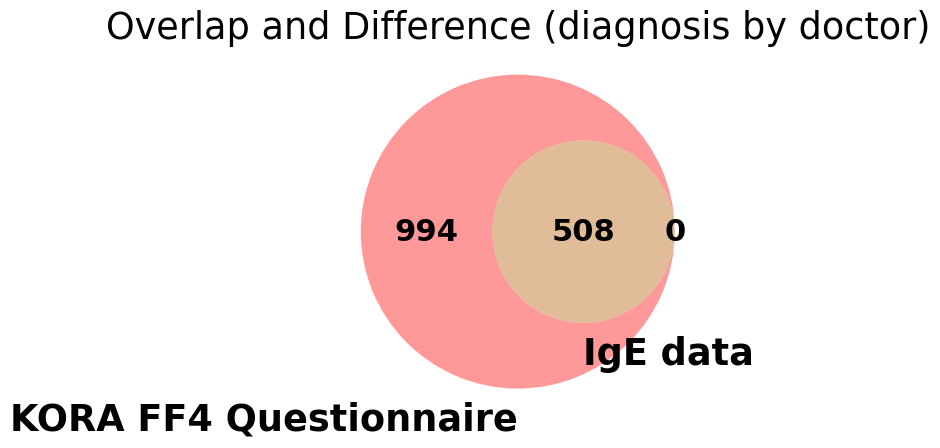

In [44]:
venn2([list1, list2], ('KORA FF4 Questionnaire', 'IgE data'))
plt.title("Overlap and Difference (diagnosis by doctor)")
plt.show()

## Overlap Analysis of IgE Sensitization and Survey Data
To understand the relationship between IgE sensitization and clinical or demographic variables, we compare the overlap of sample identifiers across the IgE dataset and survey data. The Venn diagram visualizes the intersection and unique contributions of each dataset, helping to identify individuals with both IgE-mediated allergy data and detailed survey responses. This step is essential for ensuring robust downstream analyses.

## Preparing IgE Sensitization Data for Clustering
This section focuses on preparing the IgE sensitization data for clustering analysis. We merge, filter, and select relevant features to ensure that the dataset accurately represents IgE-mediated allergy profiles. The resulting data will be used to identify patterns and subgroups among individuals based on their IgE sensitization status.

In [11]:
col_exclude = ["IgE", "IgG"]
food_features = ["nut", "milk", "wheat", "soy", "celery", "fish", "apple", "egg", "kiwi", "peach", "meat", "shrimp", "bean"]

In [12]:
ige_prep = (
    merge_ige(id_df=zz_nr, ige_df=ige, taxa_df=kora_52)
    .pipe(save_dataframe, file_path="data/ige_kora.csv", index=True)
    .pipe(overlap_with_16s_samples, ids_to_select=overlap_ige_16s_ids)
    .pipe(save_dataframe, file_path="data/ige_kora_16s.csv", index=True)
    .pipe(drop_selected_features, mask=ige_mask, col_exclude=col_exclude)
    .pipe(drop_zero_features)
    .pipe(save_dataframe, file_path="data/ige_kora_subset_all.csv", index=True)
    .pipe(save_dataframe, file_path="data/ige_kora_subset.csv", index=True)
    .pipe(select_features, columns=food_features)
    .pipe(save_dataframe, file_path="data/ige_food.csv", index=True)
    .pipe(aggregate_features, columns=food_features)
    .pipe(filter_counts, threshold=5)
    .pipe(intersect_features, count_df=count_table)
    .pipe(save_dataframe, file_path="data/obs_ige_food.csv", index=True)
)

Drop Counter({'herring_worm': 1, 'u3g_hev_b_3': 1, 'u3g_hev_b_5': 1})
Any null values? False
Columns dropped (all zeros): ['cow_milk_serum_albumin', 'buck_wheat_2s_albumin', 'german_cockroach_g2', 'apreading_pellitory']
Columns dropped (all zeros): ['cow_milk_serum_albumin', 'buck_wheat_2s_albumin', 'german_cockroach_g2', 'apreading_pellitory']
Now, data represents presence/absence information!
Number of samples in count table: 526
Number of samples with IgE measurements: 508
Number of samples in intersection: 341
Now, data represents presence/absence information!
Number of samples in count table: 526
Number of samples with IgE measurements: 508
Number of samples in intersection: 341


## Hierarchical Clustering of IgE Sensitization Profiles
Hierarchical clustering is applied to the processed IgE sensitization data to identify groups of individuals with similar IgE-mediated allergy profiles. This unsupervised learning approach helps reveal natural subgroups and patterns in the data, which may correspond to distinct clinical phenotypes or sensitization patterns. The resulting clusters can be visualized and further analyzed to understand the diversity of IgE responses.

In [22]:
ige_data = pd.read_csv("data/ige_kora_subset_all.csv", sep=",", index_col ="u3_16s_id", low_memory=False)
control_samples = pd.read_csv("data/control_samples.csv", sep=",", index_col =0, low_memory=False)
latent_allergy_components = pd.read_csv("data/latent_allergy_components.csv", sep=",", index_col =0, low_memory=False)

control_samples = ige_data[ige_data.eq(0).all(axis=1)]
test_samples = ige_data.drop(control_samples.index)

In [23]:
method = 'complete'
metric = "jaccard"

# Hierarchical clustering for samples (rows)
row_linkage = sch.linkage(test_samples, method=method, metric=metric)
row_order = sch.dendrogram(row_linkage, no_plot=True)['leaves']

# Hierarchical clustering for IgEs (columns)
col_linkage = sch.linkage(test_samples.transpose(), method=method, metric=metric)
col_order = sch.dendrogram(col_linkage, no_plot=True)['leaves']

# Reorder both rows and columns
ige_clustered = test_samples.iloc[row_order, col_order]

In [24]:
vis_ige = pd.read_csv("data/ige_clustered_275.csv", sep=",", index_col =0, low_memory=False)

idx_tuples = list(map(str, zip(vis_ige.reset_index().index, vis_ige.index)))

fig = presence_absence_heatmap(vis_ige, row_labels=idx_tuples, column_labels=vis_ige.columns, height=1000, width=500)

fig.show()

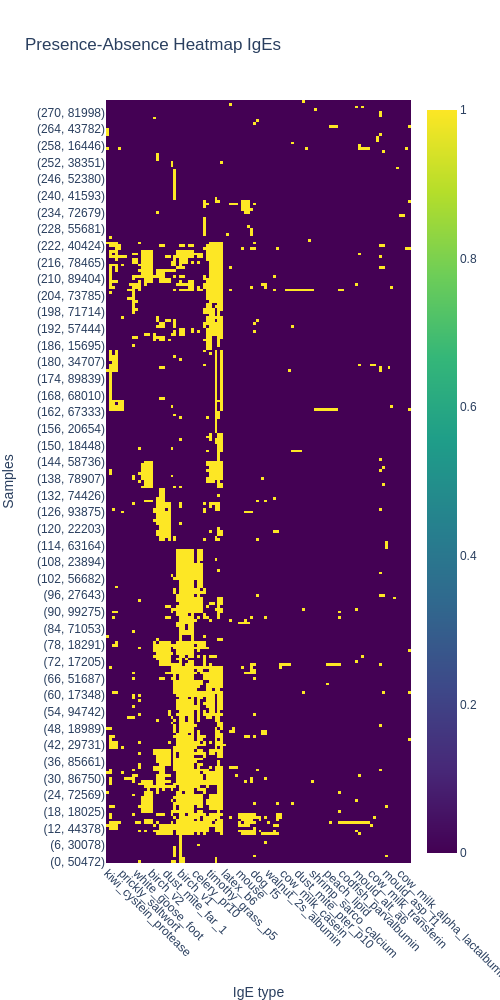

In [27]:
fig.write_image('figures/presence_absence_heatmap.png')
plt.close('all')

img = Image.open('figures/presence_absence_heatmap.png')
display.display(img)

## Visualization of Clustered IgE Sensitization Data
The clustered IgE sensitization data is visualized using a presence-absence heatmap. This plot provides an overview of the distribution and co-occurrence of IgE-mediated allergy responses across individuals and allergens. Patterns in the heatmap can highlight common sensitization profiles and rare IgE responses, supporting further interpretation and hypothesis generation.

### IgE Sensitization Data Analysis
This section explores the distribution and characteristics of IgE-mediated allergy responses in the dataset. We use statistical summaries and visualizations to better understand the prevalence and patterns of IgE sensitization among individuals.

In [28]:
vis_ige = pd.read_csv("data/ige_kora_subset_all.csv", sep=",", index_col ="u3_16s_id", low_memory=False)

# do log-normalization
fig = px.box(np.log1p(vis_ige), title='IgE Expression', width=1000, height=600)
fig.update_xaxes(tickangle=45)
fig.update_layout(yaxis_title='log-scaled values')
fig.update_traces(marker_color='#641E62')
fig.add_shape(type='line', x0=0, x1=1, xref='paper', y0=0.3, y1=0.3, yref='y',line=dict(color='#F74E6B', width=2))
fig.show()

/opt/python3_env/lib/python3.10/site-packages/plotly/express/_core.py:1223: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/opt/python3_env/lib/python3.10/site-packages/plotly/express/_core.py:1223: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/opt/python3_env/lib/python3.10/site-packages/plotly/express/_core.py:1223: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) inste

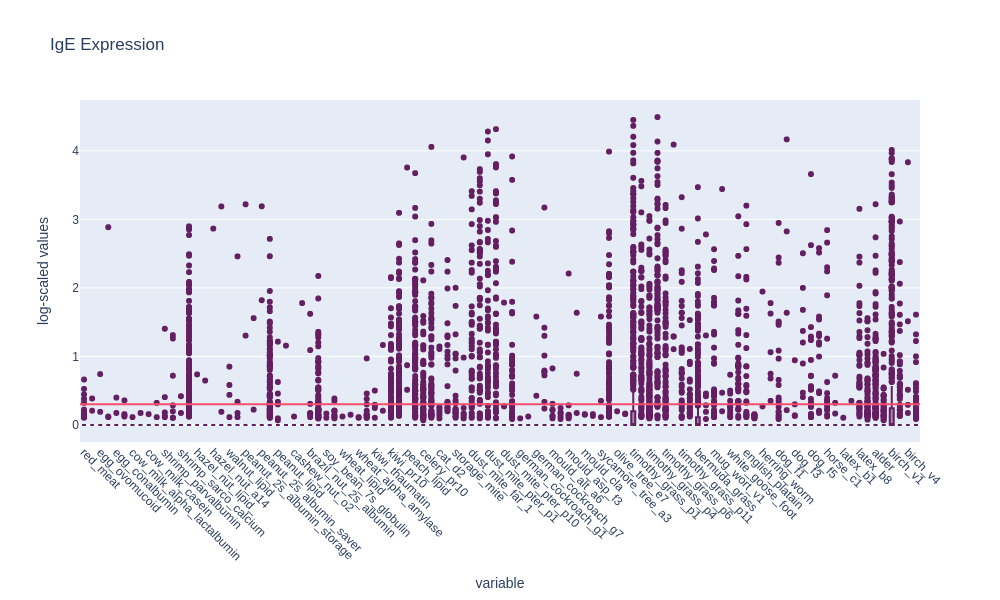

In [29]:
fig.write_image('figures/ige_expression_boxplot.png')
plt.close('all')

img = Image.open('figures/ige_expression_boxplot.png')
display.display(img)

### Summary Statistics for IgE Sensitization
This section provides summary statistics for individuals with and without IgE-mediated allergy (IgE sensitization). We compare demographic and clinical variables between groups to identify potential associations and differences relevant to IgE responses.

In [30]:
vis_ige_data = pd.read_csv("data/ige_kora_16s.csv", sep=",", index_col=0, low_memory=False)
test_vis_ige_data = vis_ige_data.loc[vis_ige_data.index.isin(test_samples.index)]
ctrl_vis_ige_data = vis_ige_data.loc[vis_ige_data.index.isin(control_samples.index)]
test_vis_ige_data["ige_status"] = 1
ctrl_vis_ige_data["ige_status"] = 0
df = pd.concat([test_vis_ige_data, ctrl_vis_ige_data])

In [31]:
vis_ige_data = pd.read_csv("data/ige_kora_16s.csv", sep=",", index_col=0, low_memory=False)

# Count the occurrences of each value in the 'allergy_or_intolerance' column
allergy_intolerance_counts = vis_ige_data['allergy_or_intolerance'].value_counts()
print(allergy_intolerance_counts)
print("\n")
# Create sets of sample indices
set_test_samples = set(test_samples.index)
set_control_samples = set(control_samples.index)

# Create sets of indices for samples with and without allergies/intolerances
indices_allergy_intolerance = set(vis_ige_data[vis_ige_data['allergy_or_intolerance'] == 0].index)  # Test samples
indices_no_allergy_intolerance = set(vis_ige_data[vis_ige_data['allergy_or_intolerance'] == 1].index)  # Control samples

# Calculate the intersection and difference of sets
intersection_with_test_samples = indices_allergy_intolerance.intersection(set_test_samples)
difference_with_test_samples = indices_allergy_intolerance.difference(set_test_samples)
num_all_samples = len(set_test_samples)
num_intersection_with_test_samples = len(intersection_with_test_samples)
num_difference_with_test_samples = len(difference_with_test_samples)

# Calculate the intersection and difference of sets
intersection_with_control_samples = indices_no_allergy_intolerance.intersection(set_control_samples)
difference_with_control_samples = indices_no_allergy_intolerance.difference(set_control_samples)
num_control_samples = len(control_samples)
num_intersection_with_control_samples = len(intersection_with_control_samples)
num_difference_with_control_samples = len(difference_with_control_samples)

# Print the results
print("Total number of test samples:", num_all_samples)
print("Survey samples WITH allergy/intolerance:", len(indices_allergy_intolerance))
print("Survey intersection with test samples:", num_intersection_with_test_samples)
print("Survey difference with test samples:", num_difference_with_test_samples)
print("\n")
print("Total number of control samples:", num_control_samples)
print("Survey samples WITHOUT allergy/intolerance::", len(indices_no_allergy_intolerance))
print("Survey difference with control samples", num_difference_with_control_samples)
print("Survey intersection with control samples:", num_intersection_with_control_samples)

allergy_or_intolerance
0.0    255
1.0    253
Name: count, dtype: int64


Total number of test samples: 275
Survey samples WITH allergy/intolerance: 255
Survey intersection with test samples: 191
Survey difference with test samples: 64


Total number of control samples: 233
Survey samples WITHOUT allergy/intolerance:: 253
Survey difference with control samples 84
Survey intersection with control samples: 169


In [32]:
test_vis_ige_data = vis_ige_data.loc[vis_ige_data.index.isin(set_test_samples)]
ctrl_vis_ige_data = vis_ige_data.loc[vis_ige_data.index.isin(set_control_samples)]

test_vis_ige_data["ige_status"] = 1
ctrl_vis_ige_data["ige_status"] = 0 

df = pd.concat([test_vis_ige_data, ctrl_vis_ige_data])

selected_cols = ['age', 'sex', 'bmi']
extra_cols = ['education','phys_activity', 'smoking_behaviour']

for col in extra_cols:
    print(ctrl_vis_ige_data[col].value_counts())
    
### ATOPIC Diseases: 0 - yes, 1 - no    
atopic_disease = ['wheezing', 'asthma', 'medicine', 'neurodermatitis', 'hay_fever', 'allergy_or_intolerance']
    
for col in atopic_disease:

    test_counts, test_per  = test_vis_ige_data[col].value_counts(), test_vis_ige_data[col].value_counts(normalize=True) * 100
    ctrl_counts, ctrl_per = ctrl_vis_ige_data[col].value_counts(), ctrl_vis_ige_data[col].value_counts(normalize=True) * 100

    print("Allergic", test_counts, test_per)
    print("Healthy", ctrl_counts, ctrl_per)
    print("\n")

education
1.0    90
3.0    72
2.0    71
Name: count, dtype: int64
phys_activity
2.0    154
4.0     49
3.0     30
Name: count, dtype: int64
smoking_behaviour
4.0    103
3.0     92
1.0     38
Name: count, dtype: int64
Allergic wheezing
1.0    242
0.0     33
Name: count, dtype: int64 wheezing
1.0    88.0
0.0    12.0
Name: proportion, dtype: float64
Healthy wheezing
1.0    225
0.0      8
Name: count, dtype: int64 wheezing
1.0    96.566524
0.0     3.433476
Name: proportion, dtype: float64


Allergic asthma
1.0    236
0.0     39
Name: count, dtype: int64 asthma
1.0    85.818182
0.0    14.181818
Name: proportion, dtype: float64
Healthy asthma
1.0    227
0.0      6
Name: count, dtype: int64 asthma
1.0    97.424893
0.0     2.575107
Name: proportion, dtype: float64


Allergic medicine
1.0    256
0.0     19
Name: count, dtype: int64 medicine
1.0    93.090909
0.0     6.909091
Name: proportion, dtype: float64
Healthy medicine
1.0    230
0.0      3
Name: count, dtype: int64 medicine
1.0    98.712446

### Co-occurrence Heatmap of IgE Sensitization
This section visualizes the co-occurrence of IgE-mediated allergy (IgE sensitization) responses across different allergens. The heatmap highlights which IgE sensitizations tend to appear together in individuals, providing insight into common patterns and potential cross-reactivities.

In [33]:
vis_ige = pd.read_csv("data/ige_clustered_275.csv", sep=",", index_col =0, low_memory=False)

N = 508
co_occurrence_matrix = vis_ige.T.dot(vis_ige)
co_occurrence_matrix = co_occurrence_matrix / N * 100

top_cooccurring_pairs = co_occurrence_matrix.unstack().sort_values(ascending=False).reset_index()

top_cooccurring_pairs.columns = ['Allergy_1', 'Allergy_2', 'Co-occurrence']

# # Filter the co-occurrence matrix to include only pairs with non-zero co-occurrence
filtered_co_occurrence_matrix = co_occurrence_matrix.loc[
    co_occurrence_matrix.gt(0).any(axis=1), 
    co_occurrence_matrix.gt(0).any(axis=0)
]

# Create an interactive heatmap using Plotly
fig = px.imshow(filtered_co_occurrence_matrix.values, 
                x=filtered_co_occurrence_matrix.columns, 
                y=filtered_co_occurrence_matrix.index,
                color_continuous_scale='magma_r', 
                labels=dict(color='Co-occurrence'))

fig.update_layout(title='Allergy Co-occurrence Heatmap', xaxis_title='Allergies', yaxis_title='Allergies',
                  height=1000, width=1000)

fig.show()

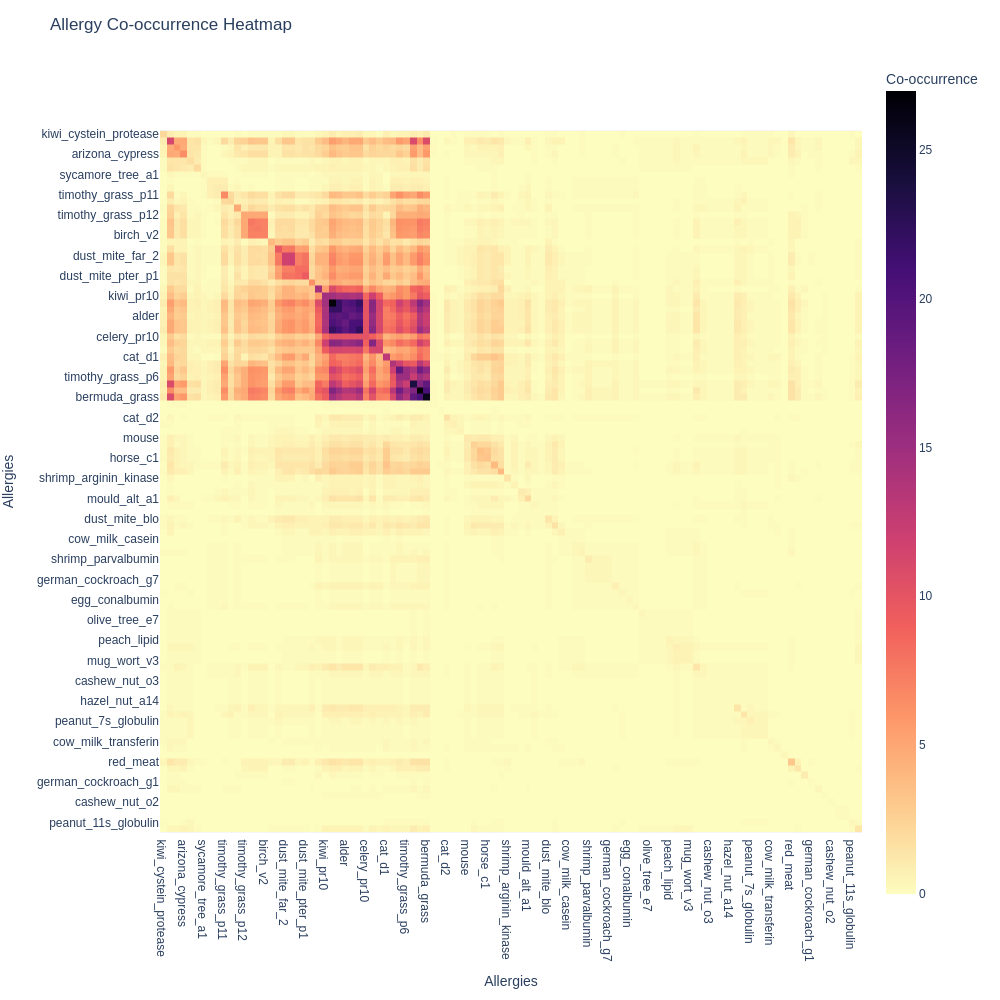

In [34]:
fig.write_image('figures/cooccurrence_heatmap.png')
plt.close('all')

img = Image.open('figures/cooccurrence_heatmap.png')
display.display(img)

### Latent IgE Sensitization Component Analysis
In this section, we use dimensionality reduction techniques to identify latent components underlying IgE sensitization profiles. Principal component analysis (PCA) and varimax rotation help uncover hidden patterns and groupings among IgE-mediated allergy responses, supporting a deeper understanding of sensitization mechanisms.

In [35]:
from sklearn.decomposition import PCA
from numpy import eye, asarray, dot, sum, diag
from numpy.linalg import svd

In [36]:
def varimax(Phi, gamma=1.0, q=20, tol=1e-6):
    """
    Performs a varimax rotation on a matrix of factor loadings to simplify the structure.

    Varimax rotation is an orthogonal rotation method that maximizes the variance of squared
    loadings of each factor, making the output easier to interpret by increasing the contrast
    in loadings. This method is commonly used after principal component analysis (PCA) or factor
    analysis.

    Parameters:
    ----------
    Phi : ndarray of shape (p, k)
        The matrix of loadings, where `p` is the number of variables and `k` is the number
        of components or factors. Each column represents a factor, and each row represents
        a variable's loading on that factor.

    gamma : float, optional, default=1.0
        The normalization parameter. A value of 1.0 indicates standard varimax rotation.
    
    q : int, optional, default=20
        The maximum number of iterations for the rotation process.

    tol : float, optional, default=1e-6
        The tolerance for convergence. The rotation stops if the change in the criterion
        falls below this threshold between iterations.

    Returns:
    -------
    ndarray of shape (p, k)
        The rotated loading matrix with the same dimensions as `Phi`, where the loadings
        are modified to achieve simpler structure and better interpretability.

    Notes:
    -----
    The varimax algorithm performs an orthogonal rotation by iteratively updating a
    rotation matrix `R` to maximize the variance of squared loadings across each factor.
    Convergence is determined by monitoring the change in the objective function `d`.

    """
    p, k = Phi.shape
    R = eye(k)
    d = 0
    for i in range(q):
        d_old = d
        Lambda = dot(Phi, R)
        u, s, vh = svd(dot(Phi.T, asarray(Lambda)**3 - (gamma / p) * dot(Lambda, diag(diag(dot(Lambda.T, Lambda))))))
        R = dot(u, vh)
        d = sum(s)
        if d_old != 0 and d / d_old < 1 + tol:
            break
    return dot(Phi, R)

In [37]:
N = 508 ### total number of individuals
co_occurrence_matrix = vis_ige.T.dot(vis_ige)
n_iges = len(co_occurrence_matrix)

pca = PCA(n_components=n_iges)

# Step 1: Ger the principal components of IgE data
ige_pcs = pca.fit_transform(co_occurrence_matrix)

# Step 2: Project the sample data onto the IgE principal components
projected_samples = vis_ige.dot(pca.components_.T)

columns=[f'PC{i+1}' for i in range(projected_samples.shape[1])]
projected_samples.columns = columns

In [38]:
explained_variance = pca.explained_variance_ratio_

fig = go.Figure()

fig.add_trace(go.Bar(
    x=list(range(1, len(explained_variance) + 1)),
    y=explained_variance * 100,
))

fig.update_layout(
    title='Scree Plot',
    xaxis_title='Principal Component',
    yaxis_title='Percentage of Variance Explained',
    template='plotly_white',
    width=900, height=500
)

fig.show()

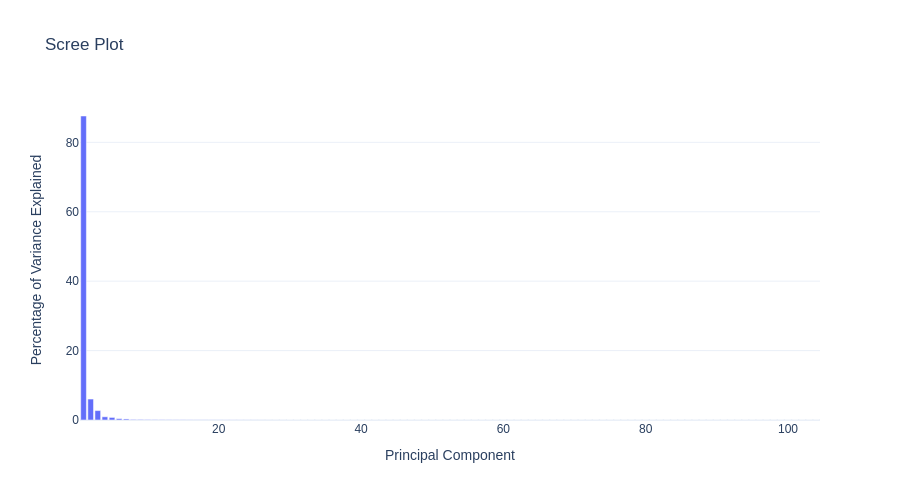

In [45]:
fig.write_image('figures/scree_plot.png')
plt.close('all')

img = Image.open('figures/scree_plot.png')
display.display(img)

In [46]:
vis_ige = pd.read_csv("data/ige_clustered_275.csv", sep=",", index_col =0, low_memory=False)
cluster_df = pd.read_csv("data/cluster_df_latent.csv", sep=",", index_col =0, low_memory=False)

cluster_df.index = vis_ige.index
cluster_df.index.name = vis_ige.index.name

join_df = projected_samples.join(cluster_df['cluster'])

In [47]:
loadings = pca.components_.T

loadings_df = pd.DataFrame(
    loadings,
    index=co_occurrence_matrix.columns,  # Use original variable names if available
    columns=[f'PC{i+1}' for i in range(n_iges)]
)

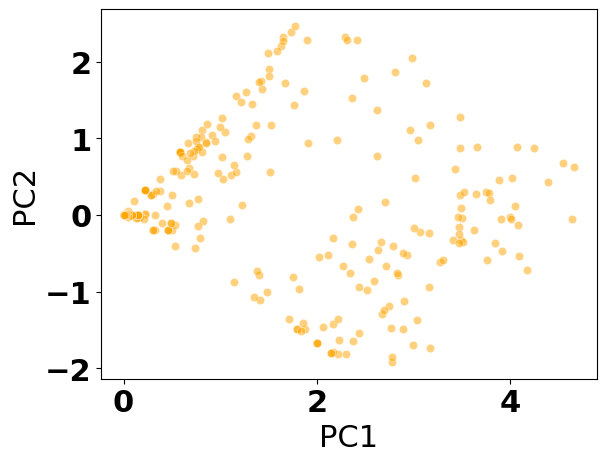

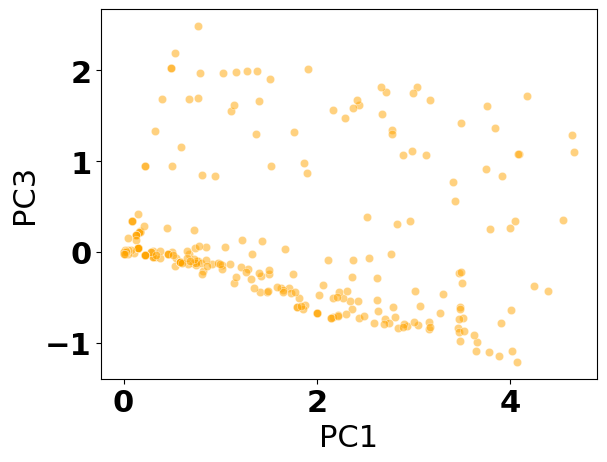

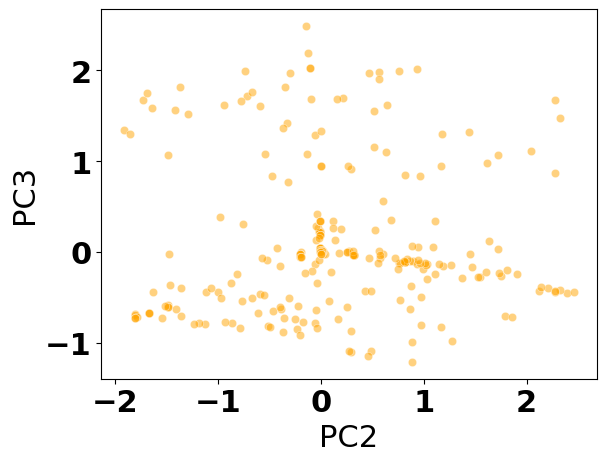

In [48]:
projected_samples_pca = vis_ige.dot(loadings)
pca_df = pd.DataFrame(projected_samples_pca)

### PC1 vs PC2
sns.scatterplot(data=pca_df, x=pca_df.columns[0], y=pca_df.columns[1], color="orange", alpha=0.5)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

### PC1 vs PC3
sns.scatterplot(data=pca_df, x=pca_df.columns[0], y=pca_df.columns[2], color="orange", alpha=0.5)
plt.xlabel("PC1")
plt.ylabel("PC3")
plt.show()

### PC2 vs PC3
sns.scatterplot(data=pca_df, x=pca_df.columns[1], y=pca_df.columns[2], color="orange", alpha=0.5)
plt.xlabel("PC2")
plt.ylabel("PC3")
plt.show()

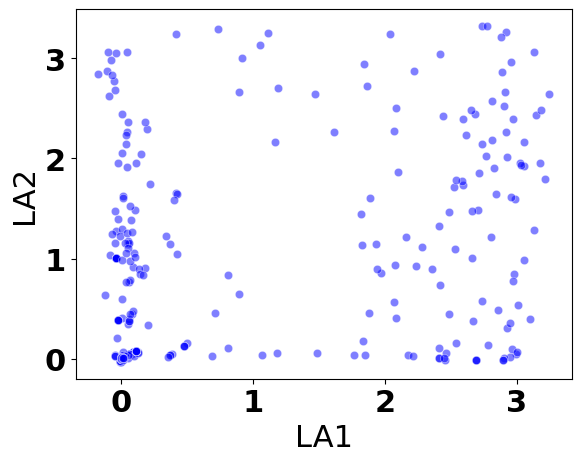

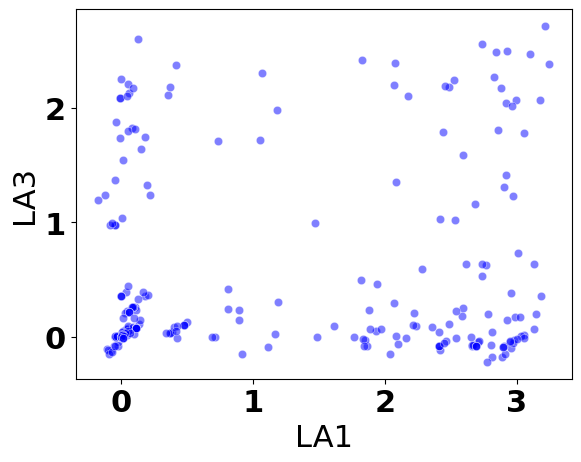

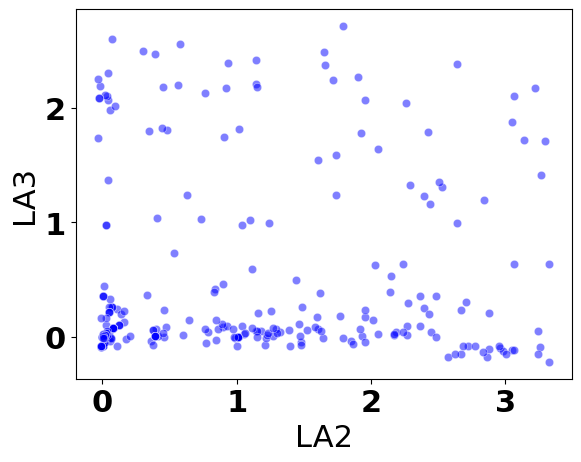

In [49]:
top_3_pcs = loadings_df.iloc[:, :3]

sparse_loadings = varimax(top_3_pcs.values)
sparse_loadings.shape

rotated_projected_samples_pca = vis_ige.dot(sparse_loadings)
rotated_pca_df = pd.DataFrame(rotated_projected_samples_pca)

# PC1 vs PC2 (LA1 vs LA2)
sns.scatterplot(data=rotated_pca_df, x=rotated_pca_df.columns[0], y=rotated_pca_df.columns[1], color="blue", alpha=0.5)
plt.xlabel("LA1")
plt.ylabel("LA2")
plt.show()

# PC1 vs PC3 (LA1 vs LA3)
sns.scatterplot(data=rotated_pca_df, x=rotated_pca_df.columns[0], y=rotated_pca_df.columns[2], color="blue", alpha=0.5)
plt.xlabel("LA1")
plt.ylabel("LA3")
plt.show()

# PC2 vs PC3 (LA2 vs LA3)
sns.scatterplot(data=rotated_pca_df, x=rotated_pca_df.columns[1], y=rotated_pca_df.columns[2], color="blue", alpha=0.5)
plt.xlabel("LA2")
plt.ylabel("LA3")
plt.show()

In [50]:
colors = [
    '#0072B2',  # Blue
    '#E69F00',  # Orange
    '#CC79A7',  # Pink
    '#D55E00',  # Dark Orange
    '#F0E442',  # Yellow
    '#009E73',  # Green
    '#A6761D',  # Brown
    '#56B4E9',  # Light Blue (from same color family)
    '#999999'   # Grey (neutral, fits well)
]

rotated_pca_df.columns = ['LA1', 'LA2', 'LA3']

join_df = rotated_pca_df.join(cluster_df['cluster'])

fig = px.scatter_3d(
    join_df, 
    x='LA1', y='LA2', z='LA3', 
    template="plotly_white",
    text=rotated_pca_df.index, 
    color='cluster', 
    color_discrete_sequence=colors 
)

fig.update_traces(
    marker=dict(size=7, line=dict(width=1, color='DarkSlateGrey')),
    textposition="top center",
    textfont_size=1
)

fig.update_layout(
    title={'text': "3D PCA Scatter Plot", 'x': 0.5},
    legend_title="Cluster",
    width=800, 
    height=800
)

fig.show()

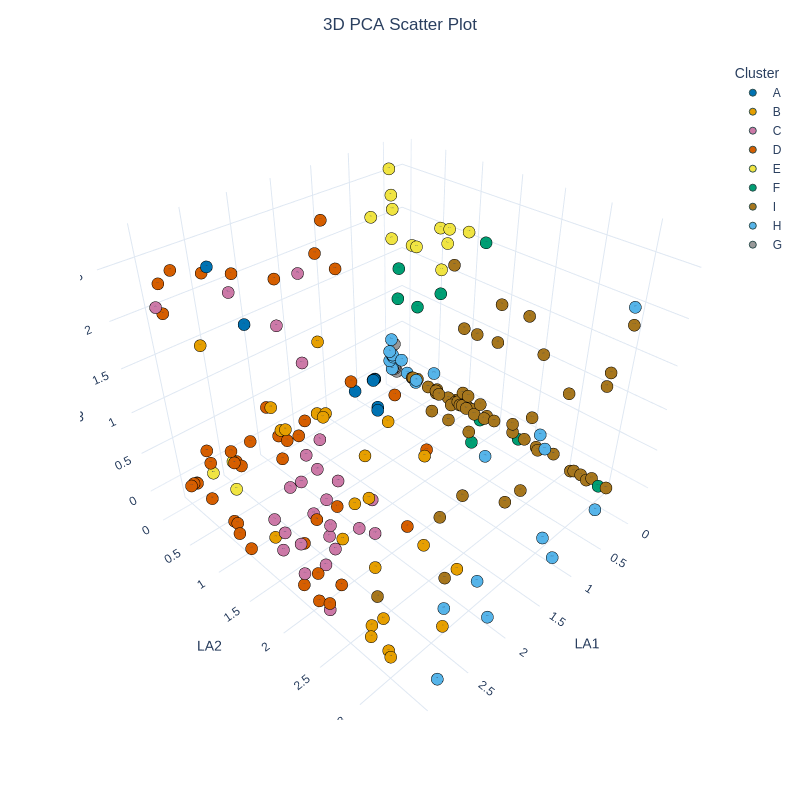

In [ ]:
img = Image.open('figures/LAC_cube.png')
display.display(img)